In [1]:
# import basic EDA libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# import model related libraries
import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ndcg_score
from collections import defaultdict
import tensorflow as tf
import math

# import libraries to save the model
import pickle
import os

### 1. Data Load, EDA & Preprocessing

In [2]:
# load the synthetic ratings data
ratings_data_syn = pd.read_csv('data/survey_ratings_synthetic.csv')

# change the column name for consistency with the crowdsourcing data
ratings_data_syn = ratings_data_syn.rename(columns={'Review': 'Rating'})

# load the survey ratings data
ratings = pd.read_csv('data/survey_ratings.csv')

# combine the crowdsourcing and synthetic ratings data
ratings_data = pd.concat([ratings, ratings_data_syn])
ratings_data.head()

,UserId,TitleId,Rating
0,1,0,5
1,1,1,4
2,1,13,4
3,1,14,1
4,1,15,5


In [3]:
# load the titles data
titles_data = pd.read_csv('data/survey_titles.csv')
titles_data.head()

,Unnamed: 0,TitleId,TitleName
0,0,0,000 - Video: Side Plank Pulse - Core Library |...
1,1,1,"001 - Video: Passionate, Feminine Dance"
2,2,2,002 - Video: Low Lunge - Yoga Library | Beginn...
3,3,3,"003 - Text, Video: Understanding Macronutrient..."
4,4,4,004 - Video: Wide Squat Pulse - Bodyweight Lib...


In [4]:
# combine both titles and ratings data into single dataframe
combined_df = pd.merge(ratings_data, titles_data, on='TitleId')

# remove unnecessary column 
combined_df = combined_df.drop('Unnamed: 0', axis=1)
combined_df.head()

,UserId,TitleId,Rating,TitleName
0,1,0,5,000 - Video: Side Plank Pulse - Core Library |...
1,6,0,1,000 - Video: Side Plank Pulse - Core Library |...
2,9,0,5,000 - Video: Side Plank Pulse - Core Library |...
3,14,0,5,000 - Video: Side Plank Pulse - Core Library |...
4,15,0,5,000 - Video: Side Plank Pulse - Core Library |...


In [5]:
# checkout number of unique data points
print('unique users: ', combined_df['UserId'].nunique())
print('unique titles: ', combined_df['TitleId'].nunique())
print('unique ratings', combined_df['Rating'].unique())

unique users:  5056
unique titles:  259
unique ratings [5 1 2 4 3]


<AxesSubplot: xlabel='Rating', ylabel='Count'>

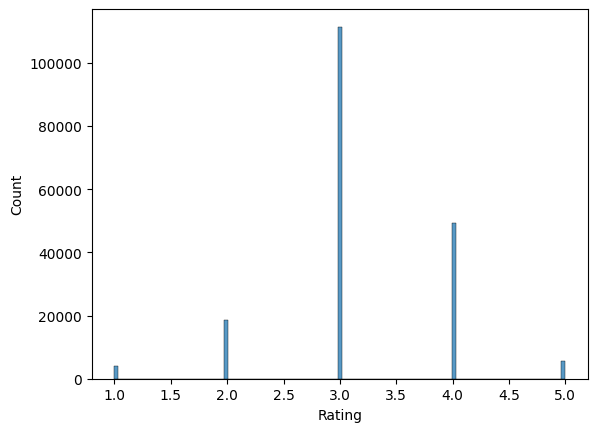

In [6]:
# analyze the rating distribution
sns.histplot(combined_df['Rating'])

In [7]:
# avg rating per user
df = combined_df.groupby('UserId').agg(avg_ratings = ('Rating', 'mean'))
df.head()

,avg_ratings
UserId,
1,3.576271
2,1.131148
3,2.910714
4,1.392857
5,4.049180


<AxesSubplot: xlabel='avg_ratings', ylabel='Count'>

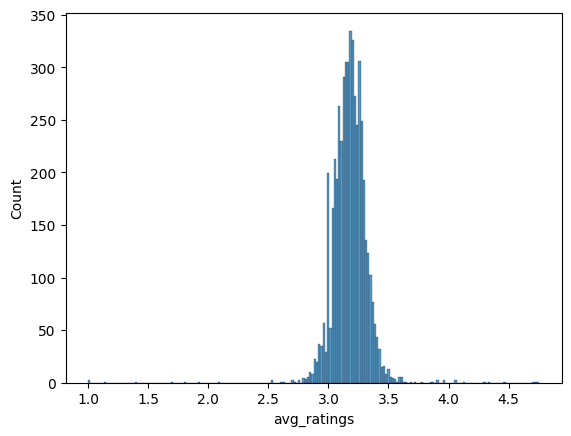

In [8]:
# analyze the average rating distribution per user
sns.histplot(df['avg_ratings'])

In [9]:
# Encode the user and title IDs into sequential data points
user_encoder = {u: i for i, u in enumerate(combined_df['UserId'].unique())}
title_encoder = {t: i for i, t in enumerate(combined_df['TitleId'].unique())}
combined_df['UserId'] = combined_df['UserId'].apply(lambda x: user_encoder[x])
combined_df['TitleId'] = combined_df['TitleId'].apply(lambda x: title_encoder[x])
combined_df.head()

,UserId,TitleId,Rating,TitleName
0,0,0,5,000 - Video: Side Plank Pulse - Core Library |...
1,1,0,1,000 - Video: Side Plank Pulse - Core Library |...
2,2,0,5,000 - Video: Side Plank Pulse - Core Library |...
3,3,0,5,000 - Video: Side Plank Pulse - Core Library |...
4,4,0,5,000 - Video: Side Plank Pulse - Core Library |...


### 2. Matrix Factorization Implementation

##### Matrix Factorization Model Summary
The model takes in a batch of users, titles and dimensions of the embeddings and outputs the predictions for the given batch of users. Embeddings are the latent features that help the model to capture different aspects and relationships (here the embeddings size is given as 100 meaning it creates a vectoe of size 100 that caputes different aspects). The model first creats the embedding for user and title and then computes the dot product to get the ouput. The output is then added with bias to get the final predictions.

Loss is computed for the batch of users the ratings are predicted using MSE loss criterion and L2 regularization is done to avoid overfitting. Once loss is computed, Adam optimizer is used to calculate the gradient with a mentioned learning rate of 0.001 and does the back propogation to update the model. This is repeated for the number of epochs(iterations) that are mentioned (here 50) to reduce the loss.

#### 2.1 Define Classes for Data Loading and Model Training

In [10]:
# define the dataset to load the dataset in the form of tensors to feed in the model
# Input is the dataset and output is tensor of (userid, titleid, rating)
class TitlesDataset(Dataset):
    def __init__(self, data):
        self.user_ids = data['UserId'].values
        self.title_ids = data['TitleId'].values
        self.ratings = data['Rating'].values
        
    def __len__(self):
        return len(self.user_ids)
    
    def __getitem__(self, idx):
        return (self.user_ids[idx], self.title_ids[idx]), self.ratings[idx]

In [11]:
# define the model
class MatrixFactorizationModel(torch.nn.Module):
    def __init__(self, num_users, num_titles, embedding_dim):
        super().__init__()
        self.user_embeddings = torch.nn.Embedding(num_users, embedding_dim) # user latent features
        self.title_embeddings = torch.nn.Embedding(num_titles, embedding_dim) # title latent features
        self.bias_user = torch.nn.Embedding(num_users, 1) 
        self.bias_title = torch.nn.Embedding(num_titles, 1)
        self.global_bias = torch.nn.Parameter(torch.tensor(combined_df['Rating'].mean()))
        
    def forward(self, user_ids, title_ids):
        user_embeds = self.user_embeddings(user_ids) # compute user embeddings
        title_embeds = self.title_embeddings(title_ids) # compute title embeddings
        user_bias = self.bias_user(user_ids) # compute user bias
        title_bias = self.bias_title(title_ids) # compite title bias
        dot_product = torch.sum(user_embeds * title_embeds, dim = 1) # compute the dot product
        output = dot_product + user_bias.squeeze() + title_bias.squeeze() + self.global_bias # introduce bias
        return output

# fefine the training loop with L2 regularization
def train_model(model, train_loader, loss_list, criterion, optimizer, num_epochs, reg_lambda):
    for epoch in range(num_epochs): # model trains for 50 epochs
        model.train() # train the model
        train_loss = 0 # instantiate the loss
        
        # load the training data in batches of 32
        for batch_idx, (inputs, ratings) in enumerate(train_loader): 
            user_ids = inputs[0]
            title_ids = inputs[1]
            ratings = ratings.float()
            outputs = model(user_ids, title_ids)
            
            # compute the loss using MSE and add L2 regularization
            loss = criterion(outputs, ratings)
            l2_reg = torch.tensor(0.)
            for param in model.parameters():
                l2_reg += torch.norm(param)
            loss += reg_lambda * l2_reg
            
            # initiate the gradient to zero
            optimizer.zero_grad()
            
            # perform back propogation
            loss.backward()
            optimizer.step()
            
            # add the current batch lose to overall loss
            train_loss += loss.item()
            
        train_loss /= len(train_loader)
        loss_list.append(train_loss)
        print('Epoch: {} Train Loss: {:.4f}'.format(epoch+1, train_loss))

#### 2.2 Train the Model

In [12]:
# split the data into training and validation sets
train, val = train_test_split(combined_df, test_size=0.2)

# instantiate the dataset and data loaders with batchsize of 32
train_dataset = TitlesDataset(train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

val_dataset = TitlesDataset(val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [13]:
# instantiate the model with number of unique user, unique titles and size of embeddings
model = MatrixFactorizationModel(num_users=len(combined_df['UserId'].unique()), 
                                 num_titles=len(combined_df['TitleId'].unique()), 
                                 embedding_dim=100)

# define the loss function as MSE
criterion = torch.nn.MSELoss()

# define the optimizer as Adam and mention the learning rate to be 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# capture the loss to plot it for visualization
loss_list = []

# train the model for 50 epochs
train_model(model, train_loader, loss_list, criterion, optimizer, num_epochs=50, reg_lambda=0.001)

Epoch: 1 Train Loss: 68.1297
Epoch: 2 Train Loss: 35.2094
Epoch: 3 Train Loss: 18.0043
Epoch: 4 Train Loss: 9.2733
Epoch: 5 Train Loss: 4.9636
Epoch: 6 Train Loss: 2.8571
Epoch: 7 Train Loss: 1.8231
Epoch: 8 Train Loss: 1.3133
Epoch: 9 Train Loss: 1.0674
Epoch: 10 Train Loss: 0.9596
Epoch: 11 Train Loss: 0.9032
Epoch: 12 Train Loss: 0.8592
Epoch: 13 Train Loss: 0.8248
Epoch: 14 Train Loss: 0.7948
Epoch: 15 Train Loss: 0.7638
Epoch: 16 Train Loss: 0.7373
Epoch: 17 Train Loss: 0.7089
Epoch: 18 Train Loss: 0.6824
Epoch: 19 Train Loss: 0.6552
Epoch: 20 Train Loss: 0.6285
Epoch: 21 Train Loss: 0.6020
Epoch: 22 Train Loss: 0.5749
Epoch: 23 Train Loss: 0.5483
Epoch: 24 Train Loss: 0.5210
Epoch: 25 Train Loss: 0.4940
Epoch: 26 Train Loss: 0.4661
Epoch: 27 Train Loss: 0.4387
Epoch: 28 Train Loss: 0.4112
Epoch: 29 Train Loss: 0.3843
Epoch: 30 Train Loss: 0.3581
Epoch: 31 Train Loss: 0.3336
Epoch: 32 Train Loss: 0.3108
Epoch: 33 Train Loss: 0.2907
Epoch: 34 Train Loss: 0.2730
Epoch: 35 Train Loss

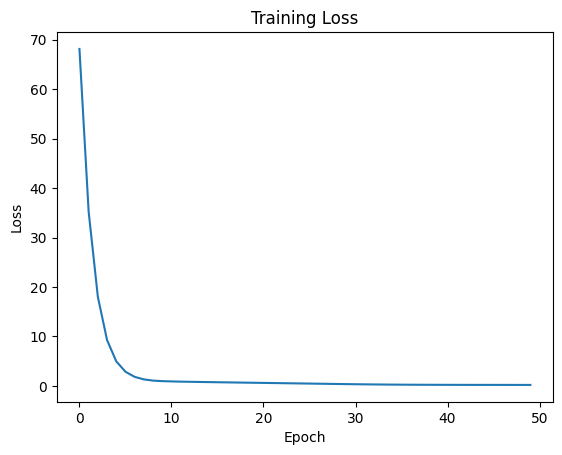

In [14]:
fig, ax = plt.subplots()

# plot the loss values
ax.plot(loss_list)

# set axis labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Loss')

# show the plot
plt.show()

#### 2.3 Save the Model

In [15]:
# Training a model takes time and it is better to save a model for later use.

# mention the path
current_directory = os.getcwd()
model_file = 'Models/Matrix_Fact_Current_Iter/matrix_fact_model_curr.pkl'
model_path = os.path.join(current_directory, model_file)

# save the trained model
with open(model_path, 'wb') as f:
    pickle.dump(model, f)

In [16]:
model_path = 'Models/Matrix_Fact_Current_Iter/matrix_fact_model_curr.pkl'

# load the saved model
with open(model_path, 'rb') as f:
    loaded_model_1 = pickle.load(f)

###### NOTE
I saved the model to 'Models/Matrix_Fact/matrix_fact_model.pkl' if I think the model performed well as a backup and save the current working version to 'Models/Matrix_Fact_Current_Iter/matrix_fact_model_curr.pkl' so that I dont mix up.

#### 2.4 Evalute the Model

In [17]:
# compute MSE and RMSE metrics.

# as we have the data in the form of tensors and using PyTorch, we use torch.no_grad() context manager to avoid the
# gradient computations as evaluation doesn't require it so that we have efficiency in time and memory.

model_output_list = []
target_rating_list = []

# evaluate the model
loaded_model_1.eval()

with torch.no_grad():
    for i, batched_data in enumerate(val_loader):
        
        # get the predictions for each batch
        model_output = loaded_model_1(batched_data[0][0], 
                       batched_data[0][1])
        model_output_list.append(model_output.sum().item() / len(batched_data[0][0]) )
        
        # get the actual ratings for each batch
        target_rating = batched_data[1]
        target_rating_list.append(target_rating.sum().item() / len(batched_data[0][0]))

# compute MSE and RMSE (if 'squared' is True returns MSE value, if False returns RMSE value)
rmse = mean_squared_error(target_rating_list, model_output_list, squared=False)
mse = mean_squared_error(target_rating_list, model_output_list, squared=True)

In [18]:
# compute other metrics
def evaluate_model(model, val_loader, threshold):
    """Compute recall, precision, f_score, and ndcg of the model on the validation set."""
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    ndcg = 0
    
    # Set the model to evaluation mode
    model.eval()
    
    with torch.no_grad():
        for batch in val_loader:
            # Unpack the batch elements
            user_ids = batch[0][0]
            movie_ids = batch[0][1]
            ratings = batch[1]

            # Predict the ratings for the validation set
            preds = model(user_ids, movie_ids).squeeze()
            
            # Compute the binary predictions using the threshold
            binary_preds = torch.where(torch.logical_and(preds >= threshold, preds <= 5), torch.ones_like(preds), torch.zeros_like(preds))
            
            binary_movie_rating = torch.where(ratings >= threshold, torch.ones_like(preds), torch.zeros_like(preds))
            # Compute the true positives, false positives, and false negatives
            true_positives += ((binary_preds == 1) & (binary_movie_rating == 1)).sum().item()
            false_positives += ((binary_preds == 1) & (binary_movie_rating == 0)).sum().item()
            false_negatives += ((binary_preds == 0) & (binary_movie_rating == 1)).sum().item()

            
            # Compute the NDCG score
            ndcg += ndcg_score(np.expand_dims(ratings, axis=0), np.expand_dims(preds, axis=0), k=10).item()
    
    # Compute the recall, precision, f_score, and ndcg
    recall = true_positives / (true_positives + false_negatives)
    precision = true_positives / (true_positives + false_positives)
    f_score = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0.0
    ndcg /= len(val_loader)
    
    return recall, precision, f_score, ndcg

In [19]:
recall, precision, f_score, ndcg = evaluate_model(loaded_model_1, val_loader, 3.5)
print(f"Recall:  {recall}, Precision: {precision}, F_score: {f_score}, Ndcg: {ndcg}")

Recall:  0.5706753931460776, Precision: 0.6636363636363637, F_score: 0.6136552465666391, Ndcg: 0.8949879527389685


In [20]:
# Predict the ratings for all the titles that the user has already rated for compute the precision@k

# a dict that stores a list of predicted rating and actual rating pair for each user 
user_est_true = defaultdict(list)

# iterate through the validation data to build the user-> [(y1, y1_hat), (y2, y2_hat)...]
loaded_model_1.eval()
with torch.no_grad():
    for i, batched_data in enumerate(val_loader): 
        users = batched_data[0][0]
        titles = batched_data[0][1]
        ratings = batched_data[1]

        
        model_output = loaded_model_1(batched_data[0][0], batched_data[0][1])

        for i in range(len(users)):
            user_id = users[i].item()
            title_id = titles[i].item() 
            pred_rating = model_output[i].item()
            true_rating = ratings[i].item()
            
            print(f"{user_id}, {title_id}, {pred_rating}, {true_rating}")
            user_est_true[user_id].append((pred_rating, true_rating, title_id))            


4133, 42, 3.3435254096984863, 3
4599, 222, 4.161627769470215, 4
4274, 73, 3.3899221420288086, 4
3317, 58, 3.6762537956237793, 1
3208, 63, 3.4854369163513184, 3
2800, 250, 4.048140048980713, 4
1626, 80, 3.525066375732422, 3
3286, 133, 3.371377468109131, 3
2822, 84, 4.014493465423584, 4
991, 47, 3.0506503582000732, 3
4963, 203, 2.426189422607422, 3
2300, 49, 3.464578628540039, 5
858, 51, 3.6074445247650146, 4
2696, 74, 3.1989378929138184, 3
2249, 94, 3.821554660797119, 4
3775, 164, 2.708038568496704, 3
1105, 41, 3.758998155593872, 3
1984, 56, 3.2342636585235596, 3
566, 148, 3.039349317550659, 3
3246, 35, 2.895045518875122, 3
2879, 84, 3.240601062774658, 3
4900, 76, 2.6973495483398438, 2
209, 237, 4.702380657196045, 4
863, 219, 3.3685011863708496, 3
1943, 194, 3.2155702114105225, 3
801, 63, 3.1104469299316406, 3
3056, 251, 3.520385265350342, 4
3382, 25, 3.169849157333374, 2
1198, 195, 3.028215169906616, 1
4784, 91, 3.118161201477051, 3
469, 119, 2.629254102706909, 3
1708, 171, 1.829106092

2516, 142, 3.0877280235290527, 2
488, 156, 3.2526004314422607, 4
3923, 97, 4.069756984710693, 4
2007, 37, 2.7052712440490723, 2
1174, 38, 3.704280376434326, 3
3990, 46, 3.2497189044952393, 3
4200, 71, 3.5489869117736816, 3
2321, 61, 3.556276559829712, 4
2447, 218, 3.4588301181793213, 3
4527, 34, 2.5190558433532715, 3
3096, 115, 4.09515905380249, 3
1681, 52, 3.0518264770507812, 3
1027, 125, 2.866255760192871, 3
4529, 44, 3.269545793533325, 5
3453, 37, 2.9549405574798584, 3
3677, 25, 2.4961585998535156, 2
1442, 194, 3.4229202270507812, 4
1178, 28, 2.2196240425109863, 3
1576, 31, 3.067023754119873, 3
1450, 215, 3.146782636642456, 3
1768, 37, 3.0838851928710938, 2
29, 115, 3.2081856727600098, 3
1898, 115, 3.296239137649536, 2
2001, 110, 3.2229745388031006, 3
326, 141, 2.9558372497558594, 3
1296, 116, 2.835055112838745, 3
4048, 12, 3.1975176334381104, 3
3229, 245, 4.113377571105957, 4
4231, 153, 3.89150333404541, 4
2382, 136, 3.2890613079071045, 3
4928, 120, 3.0187160968780518, 1
3761, 117,

4333, 152, 1.6291877031326294, 3
1755, 24, 2.345089912414551, 3
4999, 148, 4.133449554443359, 3
2924, 6, 3.2934303283691406, 3
4950, 45, 3.4002034664154053, 2
2410, 58, 4.251677513122559, 4
3913, 55, 2.936927556991577, 1
3216, 115, 3.1718740463256836, 3
1300, 37, 2.856096029281616, 2
2279, 44, 2.880455732345581, 3
3859, 34, 2.893244743347168, 2
1769, 100, 3.6806018352508545, 4
1614, 10, 3.2295165061950684, 3
2972, 136, 3.259213447570801, 3
2923, 86, 3.1104342937469482, 3
1630, 182, 2.021111249923706, 3
4822, 73, 3.646331548690796, 3
117, 108, 3.7941243648529053, 3
2135, 85, 3.314539909362793, 4
680, 61, 3.788111686706543, 4
4601, 60, 4.088836669921875, 4
3542, 22, 2.235572338104248, 2
4535, 29, 2.8328888416290283, 3
134, 38, 2.613417387008667, 3
280, 90, 2.954345703125, 3
3030, 215, 2.98822021484375, 3
2768, 167, 4.017705917358398, 4
3543, 117, 3.2259719371795654, 3
4526, 96, 3.1013221740722656, 3
2166, 224, 3.1371665000915527, 3
3854, 114, 3.0994491577148438, 3
2140, 29, 2.69729781150

In [21]:
# calculate precison and recall @k
def prec_recall_at_k(k):
    with torch.no_grad():
        precisions = dict()
        recalls = dict()
        recommended_titles = dict()

        threshold = 3.5

        for uid, user_ratings in user_est_true.items():

            # Sort user ratings by estimated value. 
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            top_k_titles = [combined_df['TitleId'][title_id] for (est, true_r, title_id) in user_ratings[:k] if est >= threshold and est <= 5]

            # Add the recommended movies to the dictionary for this user
            recommended_titles[uid] = top_k_titles[:k]

            # get the number of actual relevant item
            n_rel = sum((true_r >= threshold) for (_, true_r,_) in user_ratings)

            # get the number of recommended item that are predicted relevent and within topk
            n_rec_k = sum((est >= threshold) for (est, _, _) in user_ratings[:k])

            # get the number of recommented item that' is also actually relevant within topk
            n_rel_and_rec_k = sum(
                ((true_r >= threshold) and (est >= threshold))
                for (est, true_r, _) in user_ratings[:k]
            )

            # Precision@K: Proportion of recommended items that are relevant
            # When n_rec_k is 0, Precision is undefined. We here set it to 0.

            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

            # Recall@K: Proportion of   relevant items that are recommended
            # When n_rel is 0, Recall is undefined. We here set it to 0.

            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    return precisions, recalls

In [22]:
# print out all the metrics computed above

print(f"mse: {mse}")
print(f"rmse: {rmse}")
print()

k = [5,10,20]
for _ in k:
    precisions, recalls = prec_recall_at_k(_)
    avg_prec = sum(prec for prec in precisions.values()) / len(precisions)
    avg_rec = sum(rec for rec in recalls.values()) / len(recalls)
    f1score = (2 * avg_prec * avg_rec) / (avg_prec + avg_rec) if avg_prec + avg_rec > 0 else 0.0
    print(f"precision @ {_}: {avg_prec}")
    print(f"recall @ {_} : {avg_rec}")
    print(f"f1-score @ {_} : {f1score}")
    print('**********')
    print()

mse: 0.013649998841917829
rmse: 0.11683320949934496

precision @ 5: 0.5438192923056482
recall @ 5 : 0.48724767619907977
f1-score @ 5 : 0.5139815250457035
**********

precision @ 10: 0.5424594480957744
recall @ 10 : 0.49224134149945675
f1-score @ 10 : 0.5161317534978899
**********

precision @ 20: 0.5424485846314158
recall @ 20 : 0.4922727248409377
f1-score @ 20 : 0.5161440871045515
**********



#### 2.5 Make Recommendations

In [23]:
# define a function to get top_n recommendations
def get_user_recommendations(user_id, model, num_recommendations):
    
    # Create a list of title IDs for all titles in the dataset
    all_title_ids = torch.arange(len(combined_df['TitleId'].unique()))
    
    # Repeat the user ID for all title IDs to create pairs for predictions
    user_ids = torch.full((len(all_title_ids),), user_id, dtype=torch.long)
    
    # Create pairs of user IDs and title IDs for predictions
    inputs = (user_ids, all_title_ids)
    
    # Pass the inputs through the model to get the predicted ratings
    loaded_model_1.eval()
    with torch.no_grad():
        outputs = loaded_model_1(inputs[0], inputs[1])
    
    # Get the top-k recommended title IDs based on the predicted ratings
    _, indices = torch.topk(outputs, num_recommendations)
    recommended_title_ids = all_title_ids[indices].tolist()
    
    return recommended_title_ids

In [24]:
# set the id of the user you want the recommendatins for
user_id = 15

# get the encoded user id
user_id = user_encoder[user_id]

# set the number of recommendations to display
num_recommendations = 10

# get the recommendations
recommendations = get_user_recommendations(user_id, model, num_recommendations)

# print the recommendations
for i in recommendations:
    print(combined_df[combined_df['TitleId'] == i]['TitleName'].unique())

['195 - Audio: 15 min Beginners Core Workout | Beginner ']
['002 - Video: Low Lunge - Yoga Library | Beginner | <1 min (Shorts)  ']
['123 - Text, Video: Exploring the Art of Healthy Meal Preparation | Intermediate | 15 - 30 min  ']
['221 - What is meditation']
['202 - Video: Breathing Techniques for Health - Breathing into Emotion | Beginner | 6-15 min  ']
['039 - Audio, Text: Positive Affirmations for Confidence | Beginner | <1 min (Shorts)  ']
['000 - Video: Side Plank Pulse - Core Library | Beginner | <1 min (Shorts)  ']
['284 - Video: Breathing Techniques for Health - Heat Sensations of the Breath | Beginner | 6-15 min  ']
['085 - Audio: Affirmations for Self-Esteem | Beginner | 1-5 min  ']
['088 - Video: Jab Cross - Bodyweight Library | Beginner | <1 min (Shorts)  ']


Yes, This model's recommendations are a bit off.

### 3. Neural Network Implementation

###### Neural Network Summary

The model architecture consists of embedding layers that capture user and title characteristics as inputs for the dense layers that learn complex relationships between users and titles. Here, 5 dense layers are used(could be changed). It predicts user ratings based on user and title sequences, providing a measure of compatibility between users and titles for personalized recommendations. To avoid overfitting, dropout layers are used in between each dense layer. "MSE" is used as a loss function, "Adam" optimizer for gradient calculations and "RELU" is used as activation function for each layer.

#### 3.1 Data Load & Prep

In [25]:
# Load the synthetic data
ratings_data_syn = pd.read_csv('data/survey_ratings_synthetic.csv')
ratings_data_syn = ratings_data_syn.rename(columns={'Review': 'Rating'})

# load the crowdsourcing data
ratings = pd.read_csv('data/survey_ratings.csv')

# combine both synthetic and crowdsourcing data
ratings_data = pd.concat([ratings, ratings_data_syn])

# load the titles data
titles_data = pd.read_csv('data/survey_titles.csv')

# convert user  to sequential numerical values
user_ids = ratings_data['UserId'].unique()
user_id_map = {user_id: i for i, user_id in enumerate(user_ids)}
ratings_data['UserSeqId'] = ratings_data['UserId'].map(user_id_map)

# convert title IDs  to sequential numerical values
title_ids = ratings_data['TitleId'].unique()
title_id_map = {title_id: i for i, title_id in enumerate(title_ids)}
ratings_data['TitleSeqId'] = ratings_data['TitleId'].map(title_id_map)

# drop unnecessary columns
titles_data = titles_data.drop('Unnamed: 0', axis=1)


# join the rating and titles data
final_data = pd.merge(ratings_data, titles_data, on='TitleId')

# split the data into training and testing sets
train_data, test_data = train_test_split(ratings_data, test_size=0.2, random_state=42)

final_data

,UserId,TitleId,Rating,UserSeqId,TitleSeqId,TitleName
0,1,0,5,0,0,000 - Video: Side Plank Pulse - Core Library |...
1,6,0,1,5,0,000 - Video: Side Plank Pulse - Core Library |...
2,9,0,5,8,0,000 - Video: Side Plank Pulse - Core Library |...
3,14,0,5,13,0,000 - Video: Side Plank Pulse - Core Library |...
4,15,0,5,14,0,000 - Video: Side Plank Pulse - Core Library |...
...,...,...,...,...,...,...
188443,5989,290,4,5045,258,290 - Video: Upper Cut - Bodyweight Library | ...
188444,5990,290,3,5046,258,290 - Video: Upper Cut - Bodyweight Library | ...
188445,5993,290,3,5049,258,290 - Video: Upper Cut - Bodyweight Library | ...
188446,5996,290,3,5052,258,290 - Video: Upper Cut - Bodyweight Library | ...


#### 3.2 Model Training

In [26]:
# Define the model architecture
num_users = len(user_ids)
num_titles = len(title_ids)
embedding_size = 100 # latent features dimensions

# prepare the inputs for the neural network
user_input = tf.keras.Input(shape=(1,))
title_input = tf.keras.Input(shape=(1,))

# define the input embeddings
user_embedding = tf.keras.layers.Embedding(num_users, embedding_size)(user_input)
title_embedding = tf.keras.layers.Embedding(num_titles, embedding_size)(title_input)

# falttent the embeddings to reduce the dimensionality
user_flatten = tf.keras.layers.Flatten()(user_embedding)
title_flatten = tf.keras.layers.Flatten()(title_embedding)

# combine the input into a single input
concatenated = tf.keras.layers.Concatenate()([user_flatten, title_flatten])

# define dense layer 1 and dropout layer 1
dense1 = tf.keras.layers.Dense(64, activation='relu')(concatenated)
dropout1 = tf.keras.layers.Dropout(0.2)(dense1)

# define dense layer 2 and dropout layer 2
dense2 = tf.keras.layers.Dense(32, activation='relu')(dropout1)
dropout2 = tf.keras.layers.Dropout(0.2)(dense2)

# define dense layer 3 and dropout layer 3
dense3 = tf.keras.layers.Dense(16, activation='relu')(dropout2)
dropout3 = tf.keras.layers.Dropout(0.2)(dense3)

# define dense layer 4 and dropout layer 4
dense4 = tf.keras.layers.Dense(8, activation='relu')(dropout3)
dropout4 = tf.keras.layers.Dropout(0.2)(dense4)

# define dense layer 5 and output layer
dense5 = tf.keras.layers.Dense(4, activation='relu')(dropout4)
output = tf.keras.layers.Dense(1, activation='relu')(dense5)

# instantiate the model
model = tf.keras.Model(inputs=[user_input, title_input], outputs=output)

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# train the model
model_hist = model.fit([train_data['UserSeqId'], train_data['TitleSeqId']], train_data['Rating'],
          batch_size=32, epochs=50, validation_data=([test_data['UserSeqId'], test_data['TitleSeqId']], test_data['Rating']))

# evaluate the model
mse = model.evaluate([test_data['UserSeqId'], test_data['TitleSeqId']], test_data['Rating'])
print('Mean Squared Error:', mse)

Epoch 1/50
4712/4712 [==============================] - 10s 2ms/step - loss: 0.5663 - val_loss: 0.4192
Epoch 2/50
4712/4712 [==============================] - 9s 2ms/step - loss: 0.3442 - val_loss: 0.3925
Epoch 3/50
4712/4712 [==============================] - 10s 2ms/step - loss: 0.3336 - val_loss: 0.3507
Epoch 4/50
4712/4712 [==============================] - 9s 2ms/step - loss: 0.3241 - val_loss: 0.4050
Epoch 5/50
4712/4712 [==============================] - 9s 2ms/step - loss: 0.3130 - val_loss: 0.3957
Epoch 6/50
4712/4712 [==============================] - 9s 2ms/step - loss: 0.2988 - val_loss: 0.4142
Epoch 7/50
4712/4712 [==============================] - 9s 2ms/step - loss: 0.2865 - val_loss: 0.4105
Epoch 8/50
4712/4712 [==============================] - 9s 2ms/step - loss: 0.2762 - val_loss: 0.4482
Epoch 9/50
4712/4712 [==============================] - 9s 2ms/step - loss: 0.2658 - val_loss: 0.4298
Epoch 10/50
4712/4712 [==============================] - 9s 2ms/step - loss: 0.2

In [27]:
# Save the model architecture
model_architecture_path = 'Models/NN_Current_Iter/neural_net_architecture_curr.pkl'
with open(model_architecture_path, 'wb') as f:
    pickle.dump(model.to_json(), f)

# Save the model weights
model_weights_path = 'Models/NN_Current_Iter/neural_net_weights_curr.pkl'
model.save_weights(model_weights_path)

#### 3.3 Save the Model

NOTE: I saved the best 3 performing models to 
- 'Models/NN_Model1/....'
- 'Models/NN_Model2/....'
- 'Models/NN_Model3/....'
- current working model to 'Models/NN_Current_Iter/...'

In [28]:
model_architecture_path = 'Models/NN_Current_Iter/neural_net_architecture_curr.pkl'
with open(model_architecture_path, 'rb') as f:
    loaded_model_architecture = pickle.load(f)

loaded_model = tf.keras.models.model_from_json(loaded_model_architecture)

model_weights_path = 'Models/NN_Current_Iter/neural_net_weights_curr.pkl'
loaded_model.load_weights(model_weights_path)

#### 3.4 Evaluate the Model

In [29]:
# define function to calculate overall precision, recall and f1scores
def precision_recall_f1(actual_ratings, predicted_ratings, threshold=3):
    
    # convert the ratings and predictions to binary form based on the threshold
    actual_ratings_binary = np.array(actual_ratings) >= threshold
    predicted_ratings_binary = np.array(predicted_ratings) >= threshold

    # Calculate precision, recall, and F1 score
    precision = precision_score(actual_ratings_binary, predicted_ratings_binary)
    recall = recall_score(actual_ratings_binary, predicted_ratings_binary)
    f1_score = (2 * precision * recall) / (precision + recall)
    
    return precision, recall, f1_score

In [30]:
# make predictions
predictions_nn = loaded_model.predict([test_data['UserSeqId'], test_data['TitleSeqId']]).flatten()

# compute metrics
mse = mean_squared_error(test_data['Rating'], predictions_nn)
rmse = math.sqrt(mse)
mae = mean_absolute_error(test_data['Rating'], predictions_nn)
precision, recall, f1 = precision_recall_f1(np.array(test_data['Rating']), predictions_nn)

# display the metrics
print('MSE:', mse)
print('RMSE:', rmse)
print('MAE:', mae)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

1178/1178 [==============================] - 0s 279us/step
MSE: 0.4415643908915656
RMSE: 0.6645031157877032
MAE: 0.4916687582683487
Precision: 0.96
Recall: 0.36
F1 score: 0.53


#### 3.5 Make Recommendations

In [31]:
# define function to get top_n recommendations above a threshold ratings
def get_top_recommendations(model, user_id, n, thres=0):
    
    final_recommendation = []
    
    # get the user's sequential ID
    user_seq_id = user_id_map[user_id]
    
    num_users = len(user_ids)
    num_titles = len(title_ids)
    
    # get the inputs for the model
    title_seq_ids = np.arange(num_titles)
    user_seq_ids = np.repeat(user_seq_id, num_titles)
    
    # get the predictions from the neural network
    predictions = model.predict([user_seq_ids, title_seq_ids])
    
    # create a DataFrame with title IDs and predicted ratings
    recommendations_df = pd.DataFrame({'TitleSeqId': title_seq_ids, 'PredictedRating': predictions.flatten()})
    
    # remove the recommendations that are already seen by the user
    seen_title_ids = ratings_data[ratings_data['UserSeqId'] == user_seq_id]['TitleSeqId'].values
    recommendations_df = recommendations_df[~recommendations_df['TitleSeqId'].isin(seen_title_ids)]
    
    # Sort the recommendations by predicted rating in descending order and select the top N titles
    top_recommendations = recommendations_df.sort_values(by='PredictedRating', ascending=False)
    top_recommendations = top_recommendations[top_recommendations['PredictedRating'] >=thres].head(n)
    
    # add the recommendations and respective predicted ratings as a tuple to a list
    for _, row in top_recommendations.iterrows():
        title_seq_id = row['TitleSeqId']
        predicted_rating = row['PredictedRating']
        title_name = final_data[final_data['TitleSeqId'] == title_seq_id]['TitleName'].values[0]
        final_recommendation.append((title_name, predicted_rating))
        
    return final_recommendation

In [32]:
# display the intended number of recommendations for selected user

user_id = 15
top_n = 10

recommendations = get_top_recommendations(loaded_model, user_id, top_n)
for i in recommendations:
    print(i)

9/9 [==============================] - 0s 435us/step
('098 - Video: Core Office Workout | Beginner | 1-5 min ', 4.233172416687012)
('164 - Gratitude meditation', 4.082874774932861)
('005 - Benefits of meditation', 4.0660929679870605)
('226 - Video: Walking Meditation | Intermediate | 1-5 min  ', 3.9891245365142822)
('259 - Video: 12 Muay Thai Poses | Beginner | 1-5 min  Muay Thai', 3.889324426651001)
('155 - Audio, Text: Start Your Day with Uplifting Affirmations | Beginner | <1 min (Shorts)  ', 3.8619182109832764)
('254 - Audio, Text: Begin Your Day with Empowering Affirmations | Beginner | <1 min (Shorts)  ', 3.837056875228882)
('225 - Video: Emotional release lions breath | Intermediate | 6-15 min  ', 3.8318402767181396)
('021 - Video: Kettlebell stretching for Muay Thai | Beginner | 1-5 min  ', 3.815401315689087)
('289 - Video: Relaxation - Body Awareness | Beginner | 6-15 min  ', 3.804058313369751)


The recommendations look good for me and other couple of user.

### 4. My Thoughts on Next Steps (IMP)

There are 2 ideas here:

1. I have saved 3 models that give fairly good results. We could do more testing and select one of these models and go ahead with inputing it to a function that reorders them based on the pillar and activity scores. (If this is the case, ignore the code beyond this).


2. From the 3 models predictions, we get a total of 30 recommendations and their respective predicted ratings. And guess what, there are certain titles that are repeated across the models that indicate that these are good predictions. So, the key idea here can be of to somehow combine the predictions of these models and get the final 10 recommendations. The whole point of doing this that Model1 could have the highest precision/f1-score but the recommendations of Model2 might be more interesting to the user (defientely tested it out and found this to be true).

So, through brainstroming, I came to an approach to do so:

- First get all the 45 recommendations(top 15 from each) and merge them into a dictionary to caputure details as follows

{"title": [[ratings], #occurence]}; If a recommendation occurs only once, there will be only single value else multiple values.

Example:
{'123 - Text, Video: Exploring the Art of Healthy Meal Preparation | Intermediate | 15 - 30 min  ': [[4.104220390319824, 4.274541854858398], 2]}

- Next we take the mean values for the ones that have multiple values to get the dictionary as follows

{"title": (mean_rating, #occurence)}

Example: 
{'123 - Text, Video: Exploring the Art of Healthy Meal Preparation | Intermediate | 15 - 30 min  ': (4.19, 2)

- Next we calculate a weighted score of (0.8 * rating + 0.2 * occurence) to get the dictionary as follows

{"title": [mean_rating, #occurence, Weight_score]}


Here the assumption is that if a title is present in more models as a recommendation, it should be considered as imporatant but only a mininal weightage of 0.2 is given.

Example:
{'123 - Text, Video: Exploring the Art of Healthy Meal Preparation | Intermediate | 15 - 30 min  ': [4.19, 2, 3.533]}

- Finally, Sort the recommendation based on the weighted score and display top 10 results

- These results again can be fed to a function for reordering based on activity scores

#### 4.1 Define Functions to Load Models, get metrics and recommendations

In [33]:
def load_models():
    
    # load Model_1
    model_architecture_path = 'Models/NN_Model1/neural_net_architecture_1.pkl'
    with open(model_architecture_path, 'rb') as f:
        model_1 = pickle.load(f)

    model_1 = tf.keras.models.model_from_json(model_1)

    model_weights_path = 'Models/NN_Model1/neural_net_weights_1.pkl'
    model_1.load_weights(model_weights_path)
    
    # load Model_2
    model_architecture_path = 'Models/NN_Model2/neural_net_architecture_2.pkl'
    with open(model_architecture_path, 'rb') as f:
        model_2 = pickle.load(f)

    model_2 = tf.keras.models.model_from_json(model_2)

    model_weights_path = 'Models/NN_Model2/neural_net_weights_2.pkl'
    model_2.load_weights(model_weights_path)
    
    # load Model_3
    model_architecture_path = 'Models/NN_Model3/neural_net_architecture_3.pkl'
    with open(model_architecture_path, 'rb') as f:
        model_3 = pickle.load(f)

    model_3 = tf.keras.models.model_from_json(model_3)

    model_weights_path = 'Models/NN_Model3/neural_net_weights_3.pkl'
    model_3.load_weights(model_weights_path)
    
    return model_1, model_2, model_3

In [34]:
def get_metrics(model):
    # make predictions
    predictions = model.predict([test_data['UserSeqId'], test_data['TitleSeqId']]).flatten()

    # compute metrics
    mse = mean_squared_error(test_data['Rating'], predictions)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(test_data['Rating'], predictions)
    precision, recall, f1 = precision_recall_f1(np.array(test_data['Rating']), predictions)

    # display the metrics
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('MAE:', mae)
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    print('*********************')
    print()

In [49]:
def get_final_recommendations(model1, model2, model3, user_id, n):
    n += 5
    recommendations_1 = get_top_recommendations(model1, user_id, n)
    recommendations_2 = get_top_recommendations(model2, user_id, n)
    recommendations_3 = get_top_recommendations(model3, user_id, n)
    
    # get all the recommendations to a single dictionary

    recommendations = {}

    # Add recommendations from Model 1
    for recommendation, score in recommendations_1:
        if recommendation in recommendations:
            recommendations[recommendation][0].append(score) # add score
            recommendations[recommendation][1] +=1 # add number of times it appeared
        else:
            recommendations[recommendation] = [[],[]]
            recommendations[recommendation][0] = [score]
            recommendations[recommendation][1] = 1

    # Add recommendations from Model 2
    for recommendation, score in recommendations_2:
        if recommendation in recommendations:
            recommendations[recommendation][0].append(score)
            recommendations[recommendation][1] +=1
        else:
            recommendations[recommendation] = [[],[]]
            recommendations[recommendation][0] = [score]
            recommendations[recommendation][1] = 1

    # Add recommendations from Model 3
    for recommendation, score in recommendations_3:
        if recommendation in recommendations:
            recommendations[recommendation][0].append(score)
            recommendations[recommendation][1] +=1
        else:
            recommendations[recommendation] = [[],[]]
            recommendations[recommendation][0] = [score]
            recommendations[recommendation][1] = 1
        
    # if a title is occuring multiple times take mean rating
    mean_recommendations = {}

    for recommendation, scores in recommendations.items():
        mean_score = round(sum(scores[0]) / scores[1], 2)
        mean_recommendations[recommendation] = (mean_score, scores[1])
    
    weighted_recommendations = {}
    
    # calculate weighted score based on ratings and number of occurences
    for key, value in mean_recommendations.items():
        weighted_score = round((0.8 * value[0]) + (0.2 * value[1]),4)
        weighted_recommendations[key]= [value[0], value[1], weighted_score]

    # sort the recommendations according to the mean ratings
    sorted_recommendations = sorted(weighted_recommendations.items(), key=lambda x: x[1][2], reverse=True)
    top_10_recommendations = sorted_recommendations[:n]
    
    return recommendations_1[:10], recommendations_2[:10], recommendations_3[:10], top_10_recommendations[:10]

In [50]:
# load the models and get individual metrics

model_1, model_2, model_3 = load_models()

print('Metrics for Model 1:')
get_metrics(model_1)

print('Metrics for Model 2:')
get_metrics(model_2)

print('Metrics for Model 3:')
get_metrics(model_3)

Metrics for Model 1:
1178/1178 [==============================] - 0s 290us/step
MSE: 0.3942343317376453
RMSE: 0.6278808260630717
MAE: 0.41861660168638404
Precision: 0.94
Recall: 0.93
F1 score: 0.94
*********************

Metrics for Model 2:
1178/1178 [==============================] - 0s 279us/step
MSE: 0.3851791577576426
RMSE: 0.6206280349433488
MAE: 0.37410306825850365
Precision: 0.95
Recall: 0.87
F1 score: 0.91
*********************

Metrics for Model 3:
1178/1178 [==============================] - 0s 285us/step
MSE: 0.39152210807691323
RMSE: 0.6257172748749337
MAE: 0.3636709808702335
Precision: 0.95
Recall: 0.82
F1 score: 0.88
*********************



In [64]:
# get individual model recommendations and consolidated recommendations
recom_mod_1, recom_mod_2, recom_mod_3, final_recom = get_final_recommendations(model_1, model_2, model_3, 15, 10)

9/9 [==============================] - 0s 487us/step


In [65]:
print("Model 1 - Here are your Top 10 Recommendations:")
print()
for i in recom_mod_1:
    print(i[0], "------>", i[1])

Model 1 - Here are your Top 10 Recommendations:

123 - Text, Video: Exploring the Art of Healthy Meal Preparation | Intermediate | 15 - 30 min   ------> 4.104220390319824
021 - Video: Kettlebell stretching for Muay Thai | Beginner | 1-5 min   ------> 4.04824161529541
183 - Video: HIIT- High Intensity Interval Training  workout 2 | Intermediate | 6-15 min   ------> 4.030667304992676
289 - Video: Relaxation - Body Awareness | Beginner | 6-15 min   ------> 4.017425537109375
220 - Video: Wide Squat Hold - Bodyweight Library | Beginner | <1 min (Shorts)   ------> 3.997498035430908
260 - Video: Confidence Starts with Proper Silhouette/Posture ------> 3.9893932342529297
005 - Benefits of meditation ------> 3.987086772918701
283 - Breath work meditation ------> 3.9776382446289062
236 - Video: How to use Core Exercises Library | Beginner | 1-5 min   ------> 3.9729831218719482
134 - Video: Self Massage for recovery | Beginner | 1-5 min   ------> 3.9655256271362305


In [66]:
print("Model 2 - Here are your Top 10 Recommendations:")
print()
for i in recom_mod_2:
    print(i[0], "------>", i[1])

Model 2 - Here are your Top 10 Recommendations:

062 - Video: Wide Squat - Bodyweight Library | Beginner | <1 min (Shorts)   ------> 4.084936141967773
021 - Video: Kettlebell stretching for Muay Thai | Beginner | 1-5 min   ------> 4.051735877990723
124 - Video: 25 min Yoga Flow for Beginners - Ola teaches Magda | Beginner | 6-15 min   ------> 4.019721984863281
236 - Video: How to use Core Exercises Library | Beginner | 1-5 min   ------> 4.010512351989746
259 - Video: 12 Muay Thai Poses | Beginner | 1-5 min  Muay Thai ------> 3.996283531188965
158 - Video: Muay Thai Introduction | Beginner | <1 min (Shorts)  Muay Thai ------> 3.9909286499023438
088 - Video: Jab Cross - Bodyweight Library | Beginner | <1 min (Shorts)   ------> 3.98629093170166
279 - Video: Body Coordination - Extraordinary Rhythm ------> 3.962850570678711
225 - Video: Emotional release lions breath | Intermediate | 6-15 min   ------> 3.9613771438598633
183 - Video: HIIT- High Intensity Interval Training  workout 2 | Inte

In [67]:
print("Model 3 - Here are your Top 10 Recommendations:")
print()
for i in recom_mod_3:
    print(i[0], "------>", i[1])

Model 3 - Here are your Top 10 Recommendations:

123 - Text, Video: Exploring the Art of Healthy Meal Preparation | Intermediate | 15 - 30 min   ------> 4.274541854858398
226 - Video: Walking Meditation | Intermediate | 1-5 min   ------> 4.245354652404785
183 - Video: HIIT- High Intensity Interval Training  workout 2 | Intermediate | 6-15 min   ------> 4.134607315063477
164 - Gratitude meditation ------> 4.083175182342529
121 - Audio, Text: Positive Affirmations for Self-Love | Beginner | 1-5 min   ------> 4.074294090270996
197 - Video: Shake Out Your Stress. Getting Rid of Extra Calories ------> 4.070148468017578
039 - Audio, Text: Positive Affirmations for Confidence | Beginner | <1 min (Shorts)   ------> 4.023408889770508
180 - Video: Core workout 2 | Intermediate | 6-15 min ------> 3.9946677684783936
279 - Video: Body Coordination - Extraordinary Rhythm ------> 3.994436025619507
119 - Video: 20 min Yoga Flow for Beginners - Ola teaches Ross | Beginner | 6-15 min   ------> 3.9925928

In [68]:
print('Consolidated - Here are your Top 10 Recommendations:')
print()
for i in final_recom:
    print(i[0], "------> ", i[1][2])

Consolidated - Here are your Top 10 Recommendations:

183 - Video: HIIT- High Intensity Interval Training  workout 2 | Intermediate | 6-15 min   ------>  3.832
180 - Video: Core workout 2 | Intermediate | 6-15 min ------>  3.768
123 - Text, Video: Exploring the Art of Healthy Meal Preparation | Intermediate | 15 - 30 min   ------>  3.752
021 - Video: Kettlebell stretching for Muay Thai | Beginner | 1-5 min   ------>  3.64
197 - Video: Shake Out Your Stress. Getting Rid of Extra Calories ------>  3.616
062 - Video: Wide Squat - Bodyweight Library | Beginner | <1 min (Shorts)   ------>  3.608
226 - Video: Walking Meditation | Intermediate | 1-5 min   ------>  3.6
236 - Video: How to use Core Exercises Library | Beginner | 1-5 min   ------>  3.592
279 - Video: Body Coordination - Extraordinary Rhythm ------>  3.584
260 - Video: Confidence Starts with Proper Silhouette/Posture ------>  3.568


- By comparing the results of individual models and the consolidated recommendations, it can be decided on which approach to go forward with.

- For further passing it to through to get according to the activity scores, the recommendation obtained can be increased by increasing the "n" paramter for the "get_top_recommendations" function.